In [41]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import itertools
import nltk
import re
from nltk.corpus import stopwords
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

# Getting the data

In [2]:
df=pd.read_csv('fakenews/train.csv')

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.shape

(20800, 5)

### Missing value

In [5]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
df=df.dropna()

### We create Messages 

In [7]:
messages=df.copy()

In [8]:
messages.reset_index(inplace=True)# we do this because after drooping the missing values some of the indexes will
                                  # get dropped 

In [9]:
messages.head(10)

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
7,9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
8,10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
9,11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


In [10]:
messages['title'][3]

'15 Civilians Killed In Single US Airstrike Have Been Identified'

# Model: Bag of words and Machine Learning 

### Pre-processing

In [11]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [12]:
corpus[3]

'civilian kill singl us airstrik identifi'

### Bag of words

In [13]:
## Applying Countvectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3)) # from all the words we take the most 5000 frequent with a combination form 1 to 3 words
X = cv.fit_transform(corpus).toarray()

In [14]:
# Shape of my independent fature
X.shape

(18285, 5000)

In [15]:
# I define my dependent feature
y=messages['label']

In [16]:
# Let's see which are the most frequent words
cv.get_feature_names()[:20] 

['abandon',
 'abc',
 'abc news',
 'abduct',
 'abe',
 'abedin',
 'abl',
 'abort',
 'abroad',
 'absolut',
 'abstain',
 'absurd',
 'abus',
 'abus new',
 'abus new york',
 'academi',
 'accept',
 'access',
 'access pipelin',
 'access pipelin protest']

In [17]:
# Let's see which parameter where applied 
cv.get_params() 

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

### Train test split

In [18]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [19]:
# We convert X_train into a dataframe
count_df = pd.DataFrame(X_train, columns=cv.get_feature_names())

In [20]:
count_df.head()

,abandon,abc,abc news,abduct,abe,abedin,abl,abort,abroad,absolut,...,zero,zika,zika viru,zionist,zone,zone new,zone new york,zoo,zu,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Machine Learning Model: MultinomialNB Algorithm

In [22]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

In [23]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

### Accuracy

In [24]:
score = metrics.accuracy_score(y_train, classifier.predict(X_train))
print("train accuracy:   %0.3f" % score)

train accuracy:   0.924


In [25]:
score = metrics.accuracy_score(y_test, pred)
print("test accuracy:   %0.3f" % score)

test accuracy:   0.901


Confusion matrix, without normalization


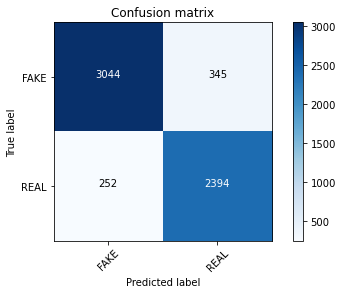

In [26]:
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

# Model: One hot representation and Neural Network with one LSTM 

### One hot Representation

In [27]:
### Vocabulary size
voc_size=5000

In [28]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[3182, 4642, 3170, 4068, 3530, 2141, 1226, 4973, 1104, 3655],
 [3333, 1792, 4878, 3783, 1439, 3853, 236],
 [193, 347, 4172, 897],
 [4835, 4976, 1268, 1876, 2932, 2019],
 [3574, 1439, 651, 26, 2612, 3941, 1439, 4716, 1175, 630],
 [2588,
  1226,
  4231,
  868,
  4818,
  2179,
  1345,
  1079,
  2583,
  3851,
  1235,
  2470,
  4144,
  4840,
  236],
 [4108, 79, 4201, 316, 306, 990, 2586, 2624, 1505, 837, 1624],
 [552, 602, 416, 804, 490, 3905, 2179, 3727, 1505, 837, 1624],
 [2491, 3923, 703, 3485, 2740, 332, 4740, 3444, 2179, 2424],
 [1960, 1001, 1284, 3285, 1896, 1183, 4545, 4211],
 [4389, 3356, 1972, 2725, 4551, 2009, 2868, 3981, 1908, 4157, 1800],
 [1876, 3925, 3530, 332, 2179, 490],
 [3976, 3998, 1712, 600, 1805, 4666, 1009, 1358, 4962],
 [3413, 1239, 4498, 68, 3042, 3473, 4565, 1505, 837, 1624],
 [2391, 3475, 4283, 1592, 1334, 1505, 837, 1624],
 [1706, 4059, 209, 1870, 2273, 1443, 1679, 2913, 1269, 1370],
 [3046, 2716, 1792],
 [1591, 574, 2501, 489, 2179, 215, 1317, 236],
 [1433, 998,

### Embeding representation

In [29]:
# This in order to have the same lenght 
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 4973 1104 3655]
 [   0    0    0 ... 1439 3853  236]
 [   0    0    0 ...  347 4172  897]
 ...
 [   0    0    0 ... 1505  837 1624]
 [   0    0    0 ... 3414 3002  968]
 [   0    0    0 ... 4711 1636  618]]


### Model: Neural Network with one LSTM 

In [30]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


### Convert X and y in arrays

In [31]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [32]:
X_final.shape,y_final.shape

((18285, 20), (18285,))

### Train test split

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

### Training the model

In [34]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 6s 26ms/step - loss: 0.3304 - accuracy: 0.8464 - val_loss: 0.2017 - val_accuracy: 0.9148
Epoch 2/10
192/192 [==============================] - 5s 25ms/step - loss: 0.1393 - accuracy: 0.9453 - val_loss: 0.1998 - val_accuracy: 0.9168
Epoch 3/10
192/192 [==============================] - 5s 25ms/step - loss: 0.1000 - accuracy: 0.9637 - val_loss: 0.2231 - val_accuracy: 0.9112
Epoch 4/10
192/192 [==============================] - 5s 25ms/step - loss: 0.0776 - accuracy: 0.9744 - val_loss: 0.2508 - val_accuracy: 0.9046
Epoch 5/10
192/192 [==============================] - 5s 25ms/step - loss: 0.0550 - accuracy: 0.9820 - val_loss: 0.2826 - val_accuracy: 0.9099
Epoch 6/10
192/192 [==============================] - 5s 25ms/step - loss: 0.0381 - accuracy: 0.9881 - val_loss: 0.3730 - val_accuracy: 0.9026
Epoch 7/10
192/192 [==============================] - 5s 25ms/step - loss: 0.0275 - accuracy: 0.9918 - val_loss: 0.4494 - val_accuracy: 0.9047

In [35]:
y_pred=model.predict_classes(X_test)

/usr/local/lib64/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### Accuracy

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9067108533554267

In [37]:
accuracy_score(y_train,model.predict_classes(X_train))

0.9987755102040816

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
confusion_matrix(y_test,y_pred)

array([[3109,  310],
       [ 253, 2363]])

# One hot representation representation and Neural Network with one Bidirectional LSTM 

# Model

In [42]:
## Creating model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               112800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


# Training

In [43]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 11s 42ms/step - loss: 0.3087 - accuracy: 0.8548 - val_loss: 0.1977 - val_accuracy: 0.9188
Epoch 2/10
192/192 [==============================] - 8s 41ms/step - loss: 0.1408 - accuracy: 0.9469 - val_loss: 0.2045 - val_accuracy: 0.9147
Epoch 3/10
192/192 [==============================] - 7s 38ms/step - loss: 0.1031 - accuracy: 0.9637 - val_loss: 0.2329 - val_accuracy: 0.9094
Epoch 4/10
192/192 [==============================] - 7s 38ms/step - loss: 0.0749 - accuracy: 0.9755 - val_loss: 0.2661 - val_accuracy: 0.9084
Epoch 5/10
192/192 [==============================] - 8s 39ms/step - loss: 0.0592 - accuracy: 0.9812 - val_loss: 0.3068 - val_accuracy: 0.9125
Epoch 6/10
192/192 [==============================] - 8s 43ms/step - loss: 0.0521 - accuracy: 0.9833 - val_loss: 0.4036 - val_accuracy: 0.9017
Epoch 7/10
192/192 [==============================] - 8s 39ms/step - loss: 0.0351 - accuracy: 0.9886 - val_loss: 0.4405 - val_accuracy: 0.906

In [44]:
y_pred1=model1.predict_classes(X_test)

### Accuracy

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

0.9075393537696769

In [46]:
accuracy_score(y_train,model1.predict_classes(X_train))

0.9968979591836735

In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
confusion_matrix(y_test,y_pred1)

array([[3085,  334],
       [ 224, 2392]])

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      3419
           1       0.88      0.91      0.90      2616

    accuracy                           0.91      6035
   macro avg       0.90      0.91      0.91      6035
weighted avg       0.91      0.91      0.91      6035



# Model: TFidf Vectorizer and Machine Learning

### TFidf Vectorizer

In [50]:
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()

In [51]:
X.shape

(18285, 5000)

In [52]:
y=messages['label']

In [53]:
tfidf_v.get_feature_names()[:20]

['abandon',
 'abc',
 'abc news',
 'abduct',
 'abe',
 'abedin',
 'abl',
 'abort',
 'abroad',
 'absolut',
 'abstain',
 'absurd',
 'abus',
 'abus new',
 'abus new york',
 'academi',
 'accept',
 'access',
 'access pipelin',
 'access pipelin protest']

In [54]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

### Train test split

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Converting X_train into a dataframe

In [56]:
count_df = pd.DataFrame(X_train, columns=tfidf_v.get_feature_names())

In [57]:
count_df.head()

,abandon,abc,abc news,abduct,abe,abedin,abl,abort,abroad,absolut,...,zero,zika,zika viru,zionist,zone,zone new,zone new york,zoo,zu,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.305244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model: MultinomialNB Algorithm

In [58]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

In [60]:
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

### Accuracy

In [61]:
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.880


In [62]:
score = metrics.accuracy_score(y_train, classifier.predict(X_train))
print("accuracy:   %0.3f" % score)

accuracy:   0.918


Confusion matrix, without normalization


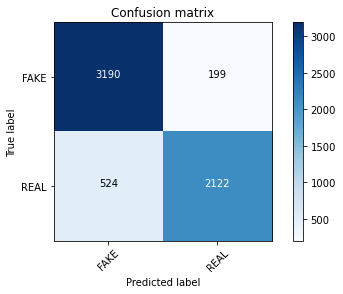

In [63]:
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])